# Описание задачи

Вы работаете в компании, которая занимается продажей автомобилей с пробегом в Москве. 

Основная задача компании и её менеджеров — максимально быстро находить выгодные предложения (проще говоря, купить ниже рынка, а продать дороже рынка). 

Руководство компании просит вашу команду создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.

Если такая модель будет работать хорошо, то вы сможете быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании.

**Метрика:** MAPE - Mean Percentage Absolute Error (средняя абсолютная ошибка в процентах).

Проект подготовлен в январе 2022 года.

# Setup

In [214]:
pip install pandas-profiling

  Using cached pandas_profiling-3.1.0-py2.py3-none-any.whl (261 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached htmlmin-0.1.12-py3-none-any.whl
  Using cached missingno-0.5.0-py3-none-any.whl (8.8 kB)
  Using cached phik-0.12.0-cp39-cp39-win_amd64.whl (659 kB)
  Using cached multimethod-1.6-py3-none-any.whl (9.4 kB)
  Using cached pydantic-1.9.0-cp39-cp39-win_amd64.whl (2.1 MB)
  Using cached visions-0.7.4-py3-none-any.whl (102 kB)
  Using cached tangled_up_in_unicode-0.1.0-py3-none-any.whl (3.1 MB)
  Using cached ImageHash-4.2.1-py2.py3-none-any.whl
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [83]:
pip install lightgbm

In [1]:
from pandas import Series
import pandas as pd
import numpy as np
import sys
import json
import csv
import re
import time
import datetime
import statistics
from tqdm.notebook import tqdm

from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas_profiling
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV

import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor 
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor, BaggingRegressor

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.3


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [2]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [4]:
def outlier(column):
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    return ('25%: {},'.format(perc25), '75%: {},'.format(perc75), "IQR: {}, ".format(IQR),
            "Outlier bounds: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

In [5]:
VERSION = 16
# подключил к ноутбуку внешний датасет
DIR_TRAIN = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TEST = '../input/sf-dst-car-price-prediction/'
VAL_SIZE = 0.20   # 20%

# Data

Посмотрим на доступные тестовые данные:

In [78]:
test = pd.read_csv(
    'C:/Users/Sveta/JupyterNotebook/datasets/sf-dst-car-price-prediction/test.csv')

Итого: в тестовом датасете данные по 12 брендам. 26 категориальных переменных, 6 - числовых. Очень много пропусков в столбцах complectation_dict и Владение. Много пропусков и в столбце equipment_dict. Один пропуск в столбце ПТС. Остальные данные - полные.

Есть данные по объявлениям с сайта auto.ru, собранные в сентябре 2020 года:

In [79]:
train = pd.read_csv(
    'C:/Users/Sveta/JupyterNotebook/datasets/sf-dst-car-price-prediction/all_auto_ru_09_09_2020.csv')

Итого: в обучающем датасете данные по 36 брендам. Есть по одному пропуску в столбцах bodyType, modelDate, name, numberOfDoors, vehicleConfiguration, vehicleTransmission, engineDisplacement, enginePower, Привод. Есть пропуски в столбцах description, Владельцы, ПТС, price. Два пустых столбца: Состояние и hidden. Остальные данные - без пропусков.

In [80]:
parsed = pd.read_csv(
    'C:/Users/Sveta/JupyterNotebook/datasets/sf-dst-car-price-prediction/train_parsed.csv')

Данные парсились с сайта auto.ru только по брендам тестового датасета. Рассматривались все города, получилось собрать только около 30 тыс. объявлений, и сразу видно, что после чистки их будет еще меньше. Возникли сложности именно со сбором ссылок на объявления. Собрать польностью все не получилось. Эти данные будут использоваться как дополнение в датасету train.

In [10]:
test.head()

bodyType  brand                                            car_url  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       синий                                                NaN   
1      чёрный                                                NaN   
2       серый  {"id":"20026336","name":"Ambition","available_...   
3  коричневый  {"id":"20803582","name":"Ambition","available_...   
4       белый                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   

                                               image  mileage  modelDate  \
0  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    74000       2013   
1  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    60563       2017   
2  https://avatars.mds.yandex.net/get-autoru-vos/...    88000       2013   
3  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    95000       2013   
4  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    58536       2008   

                                          model_info model_name  \
0  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
1  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
2  {"code":"SUPERB","name":"Superb","ru_name":"Су...     SUPERB   
3  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
4  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   

                     name  numberOfDoors  parsing_unixtime priceCurrency  \
0      1.2 AMT (105 л.с.)              5        1603226273           RUB   
1       1.6 MT (110 л.с.)              5        1603226277           RUB   
2  DSG 1.8 AMT (152 л.с.)              5        1603226280           RUB   
3       1.6 AT (110 л.с.)              5        1603226284           RUB   
4       1.8 AT (152 л.с.)              5        1603226288           RUB   

   productionDate     sell_id  \
0            2014  1100575026   
1            2017  1100549428   
2            2014  1100658222   
3            2014  1100937408   
4            2012  1101037972   

                                           super_gen     vehicleConfiguration  \
0  {"id":"10373605","displacement":1197,"engine_t...       LIFTBACK ROBOT 1.2   
1  {"id":"20913311","displacement":1598,"engine_t...  LIFTBACK MECHANICAL 1.6   
2  {"id":"20026323","nameplate":"DSG","displaceme...       LIFTBACK ROBOT 1.8   
3  {"id":"20105521","displacement":1598,"engine_t...   LIFTBACK AUTOMATIC 1.6   
4  {"id":"4561004","displacement":1798,"engine_ty...   LIFTBACK AUTOMATIC 1.8   

  vehicleTransmission    vendor    Владельцы Владение       ПТС    Привод  \
0    роботизированная  EUROPEAN  3 или более      NaN  Оригинал  передний   
1        механическая  EUROPEAN   1 владелец      NaN  Оригинал  передний   
2    роботиз

In [33]:
train.head()

bodyType brand   color fuelType  modelDate                   name  \
0            Седан  AUDI  040001   бензин     1990.0  2.8 MT (174 л.с.) 4WD   
1            Седан  AUDI  EE1D19   бензин     1982.0       1.8 MT (90 л.с.)   
2  Универсал 5 дв.  AUDI  0000CC   бензин     1988.0  2.3 MT (136 л.с.) 4WD   
3            Седан  AUDI  CACECB   бензин     1988.0       1.8 MT (90 л.с.)   
4            Седан  AUDI  040001   бензин     1990.0      2.0 MT (101 л.с.)   

   numberOfDoors  productionDate          vehicleConfiguration  \
0            4.0            1991          SEDAN MECHANICAL 2.8   
1            4.0            1986          SEDAN MECHANICAL 1.8   
2            5.0            1989  WAGON_5_DOORS MECHANICAL 2.3   
3            4.0            1989          SEDAN MECHANICAL 1.8   
4            4.0            1991          SEDAN MECHANICAL 2.0   

  vehicleTransmission engineDisplacement  enginePower  \
0          MECHANICAL                2.8        174.0   
1          MECHANICAL                1.8         90.0   
2          MECHANICAL                2.3        136.0   
3          MECHANICAL                1.8         90.0   
4          MECHANICAL                2.0        101.0   

                                         description  mileage Комплектация  \
0   Машина  в приличном состоянии ,не гнилая не р...   350000  {'id': '0'}   
1  Машина в оригинале не гнилая все вопросы по те...   173424  {'id': '0'}   
2  ПТС Оригинал!\nПолный комплект ключей!\nПо рез...   230000  {'id': '0'}   
3                                                NaN   240000  {'id': '0'}   
4  Машина не гнилая, дыр нет, днище целое, даже в...   300000  {'id': '0'}   

     Привод  Руль  Состояние  Владельцы        ПТС  Таможня Владение  \
0    полный  LEFT        NaN        3.0   ORIGINAL     True      NaN   
1  передний  LEFT        NaN        3.0   ORIGINAL     True      NaN   
2    полный  LEFT        NaN        3.0   ORIGINAL     True      NaN   
3  передний  LEFT        NaN        3.0   ORIGINAL     True      NaN   
4  передний  LEFT        NaN        3.0  DUPLICATE     True      NaN   

      price            start_date  hidden model  
0  200000.0  2019-10-03T08:09:11Z     NaN   100  
1   60000.0  2020-09-06T06:49:40Z     NaN   100  
2   99000.0  2020-09-02T14:04:21Z     NaN   100  
3   65000.0  2020-08-23T17:40:09Z     NaN   100  
4  100000.0  2020-09-08T09:22:07Z     NaN   100

In [55]:
parsed.head()

Unnamed: 0                                            car_url  \
0           0  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1           0  https://auto.ru/cars/new/group/skoda/rapid/217...   
2           0  https://auto.ru/cars/used/sale/skoda/octavia/1...   
3           0  https://auto.ru/cars/used/sale/skoda/felicia/1...   
4           0  https://auto.ru/cars/used/sale/skoda/octavia/1...   

          bodyType  brand        color  \
0  универсал 5 дв.  SKODA        белый   
1              NaN  SKODA       чёрный   
2          лифтбек  SKODA       чёрный   
3    хэтчбек 5 дв.  SKODA      зелёный   
4          лифтбек  SKODA  серебристый   

                                  complectation_dict  \
0  ['cruise-control', 'multi-wheel', 'heated-wash...   
1  ['cruise-control', 'multi-wheel', 'heated-wash...   
2  ['cruise-control', 'multi-wheel', 'heated-wash...   
3                                                 []   
4                                                 []   

                                         description engineDisplacement  \
0  Автомобиль в отличном техническом состоянии Ко...              1.8 л   
1  В стоимость автомобиля включено дополнительное...                NaN   
2  Идеальное состояние Куплена новой у дилера Шко...              1.8 л   
3     фелисия LX рестайлинг крепкая на отличном ходу              1.3 л   
4  Мотор турбина без нареканий Подвеска без стуко...              1.8 л   

  enginePower                                     equipment_dict fuelType  \
0    180 л.с.  {'cruise-control': True, 'esp': True, 'adaptiv...   Бензин   
1         NaN  {'cruise-control': True, 'asr': True, 'tinted-...      NaN   
2    180 л.с.  {'cruise-control': True, 'esp': True, 'usb': T...   Бензин   
3     58 л.с.                                                 {}   Бензин   
4    150 л.с.                                                 {}   Бензин   

                                               image     mileage  modelDate  \
0  https://avatars.mds.yandex.net/get-autoru-vos/...  240 000 км        NaN   
1  https://autoru.naydex.net/9rMCoG669/706f8ca9w/...         NaN        NaN   
2  https://autoru.naydex.net/9rMCoG669/706f8ca9w/...   63 000 км        NaN   
3  https://avatars.mds.yandex.net/get-autoru-vos/...  213 000 км        NaN   
4  https://autoru.naydex.net/9rMCoG669/706f8ca9w/...  232 000 км        NaN   

  model_name  numberOfDoors  parsing_unixtime      price priceCurrency  \
0    Octavia            NaN        1642015327  1210000.0           RUB   
1        NaN            NaN        1642015328  2310000.0           RUB   
2    Octavia            NaN        1642015329  1370000.0           RUB   
3    Felicia            NaN        1642015330    90000.0           RUB   
4    Octavia            NaN        1642015332   280000.0           RUB   

   productionDate     sell_id  vehicleConfiguration vehicleTransmission  \
0            2014  1106123284                   NaN    роботизированная   
1            2021  1106439569                   NaN                 NaN   
2            2013  1106262843                   NaN    роботизированная   
3            1998  1106511100                   NaN        механическая   
4            2003  1105927889                   NaN        механическая   

     Владельцы         Владение       ПТС    Привод   Руль  \
0  3 или более        8 месяцев  Дубликат  передний  Левый   
1          NaN              NaN       NaN       NaN    NaN   
2   1 владелец  8 лет и 1 месяц  Оригинал  передний  Левый   
3  3 или более              NaN  Оригинал  передний  Левый   
4  3 или более              NaN  Дубликат  передний  Левый   

            Состояние     Таможня               region  
0  Не требует ремонта  Растаможен              в Омске  
1                 NaN         NaN                  NaN  
2  Не требует ремонта  Растаможен             в Москве  
3  Не требует ремонта  Растаможен   в Санкт-Петербурге  
4  Не требует ремонта  Растаможен         в Чебоксарах

In [ ]:
!ls '../input'

In [ ]:
# датасет для обучения модели
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv')
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

## Data Preprocessing

### Train

Первоначальную предобработку данных проводим отдельно для трейн и тест датасетов. Детально просмотрев все столбцы в обоих датасетах с помощью функций value_counts() и unique(), пришла к выводу, что для меня проще будет сделать именно так. И уже после этого объединить датасеты.

In [9]:
# cмотрим дубли в train по всем колонкам, кроме пустых
train.duplicated(subset=['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
                         'numberOfDoors', 'productionDate', 'vehicleConfiguration',
                         'vehicleTransmission', 'engineDisplacement', 'enginePower',
                         'description', 'mileage', 'Комплектация', 'Привод', 'Руль',
                         'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
                         'model']).sum()

2114

In [81]:
# удаляем дубликаты в train
train.drop_duplicates(subset=['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
                              'numberOfDoors', 'productionDate', 'vehicleConfiguration',
                              'vehicleTransmission', 'engineDisplacement', 'enginePower',
                              'description', 'mileage', 'Комплектация', 'Привод', 'Руль',
                              'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
                              'model'], keep='first', inplace=True)

# удаляем пустые столбцы
train.drop(['hidden'], inplace=True, axis=1)
train.drop(['Состояние'], inplace=True, axis=1)

# удаляем строки, в которых нет цены
train.dropna(subset=['price'], inplace=True)

# есть одно объявление (строка 24624) с пропусками в большинстве столбцов, поскольку оно одно, удалим его
train.dropna(subset=['bodyType'], inplace=True)

# оставим в bodytype только общее название типа кузова
train['bodyType'] = train['bodyType'].apply(lambda x: x.split(' ')[0].lower())

# добавим название производителя
vendors_dict = {'AUDI': 'EUROPEAN', 'BMW': 'EUROPEAN', 'CADILLAC': 'AMERICAN', 'CHERY': 'CHINESE',
                'CHEVROLET': 'AMERICAN', 'CHRYSLER': 'AMERICAN', 'CITROEN': 'EUROPEAN', 'DAEWOO': 'KOREAN',
                'DODGE': 'AMERICAN', 'FORD': 'AMERICAN', 'GEELY': 'CHINESE', 'GREAT_WALL': 'CHINESE',
                'HONDA': 'JAPANESE', 'HYUNDAI': 'KOREAN', 'INFINITI': 'JAPANESE', 'JAGUAR': 'EUROPEAN',
                'JEEP': 'AMERICAN', 'KIA': 'KOREAN', 'LAND_ROVER': 'EUROPEAN', 'LEXUS': 'JAPANESE',
                'MAZDA': 'JAPANESE', 'MINI': 'EUROPEAN', 'MERCEDES': 'EUROPEAN', 'MITSUBISHI': 'JAPANESE',
                'NISSAN': 'JAPANESE', 'OPEL': 'EUROPEAN', 'PEUGEOT': 'EUROPEAN', 'PORSCHE': 'EUROPEAN',
                'RENAULT': 'EUROPEAN', 'TOYOTA': 'JAPANESE', 'SKODA': 'EUROPEAN', 'SSANG_YONG': 'KOREAN',
                'SUBARU': 'JAPANESE', 'SUZUKI': 'JAPANESE', 'VOLVO': 'EUROPEAN', 'VOLKSWAGEN': 'EUROPEAN'}
train['vendor'] = train['brand'].map(vendors_dict)

# переименуем цвета
colors_dict = {'040001': 'чёрный', 'FAFBFB': 'белый', '97948F': 'серый', 'CACECB': 'серебристый',
               '0000CC': 'синий', '200204': 'коричневый', 'EE1D19': 'красный',  '007F00': 'зелёный',
               'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый',
               '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}
train['color'].replace(to_replace=colors_dict, inplace=True)

# изменим тип данных на int, как в test датасете
train['modelDate'] = train['modelDate'].astype('int64')
train['numberOfDoors'] = train['numberOfDoors'].astype('int64')
train['enginePower'] = train['enginePower'].astype('int64')

# добавим parsing_unixtime как 09_09_2020 18:00
train['parsing_unixtime'] = 1599674400

# преобразуем Таможню в бинарный признак
train['Таможня'] = train['Таможня'].apply(lambda x: 1 if x == True else 0)

# в engineDisplacement много разных данных, не относящихся к литражу двигателя, возьмем данные из столбца name


def get_engineDisplacement_from_name(row: str):
    extracted_value = re.findall('\d\.\d', str(row))
    if extracted_value:
        return float(extracted_value[0])
    return None


train['engineDisplacement'] = train['name'].apply(
    get_engineDisplacement_from_name)

# NaN в engineDisplacement - это электрокары, поэтому заменим их на 0
train['engineDisplacement'].fillna(0, inplace=True)

# удалим name, т.к. информация дублируется в столбцах vehicleTransmission и enginePower
train.drop(['name'], inplace=True, axis=1)

# удалим vehicleConfiguration, т.к. информация дублируется в столбцах bodyType, vehicleTransmission и engineDisplacement
train.drop(['vehicleConfiguration'], inplace=True, axis=1)

# 66% значений - пустые, удаляем
train.drop(['Комплектация'], inplace=True, axis=1)

# есть NaN значения в столбце Владельцы, и это авто с нулевым пробегом, т.е. можем заменить кол-во владельцев на 0
train[train['Владельцы'].isnull() == True].mileage.sum()
train['Владельцы'] = train['Владельцы'].fillna('0').astype('int64')

# есть NaN значения в столбце ПТС, и это авто с нулевым пробегом, т.е. можем заменить на ORIGINAL
train[train['ПТС'].isnull() == True].mileage.sum()
train['ПТС'] = train['ПТС'].fillna('ORIGINAL')

# удаляем start_date, т.к. таких данных нет в test, и я не нашла, откуда их можно туда добавить
train.drop(['start_date'], inplace=True, axis=1)

In [11]:
# поcмотрим еще раз дубли в train
train.duplicated().sum()

1463

In [82]:
# удалим дубли в train
train.drop_duplicates(keep='first', inplace=True)

### Test

In [83]:
# переводим bodyType в нижний регистр
test['bodyType'] = test['bodyType'].apply(lambda x: x.split(' ')[0].lower())

# чистим названия в engineDisplacement, содержащие 'LTR'
test['engineDisplacement'] = test['engineDisplacement'].str.replace(' LTR', '')
test['engineDisplacement'] = test['engineDisplacement'].apply(
    lambda x: '0' if x == '' else x)
test['engineDisplacement'] = test['engineDisplacement'].astype('float64')

# чистим названия в enginePower и меняем формат на int64
test['enginePower'] = test['enginePower'].str.replace('\xa0', '')
test['enginePower'] = test['enginePower'].str.replace(' N12', '')
test['enginePower'] = test['enginePower'].astype('int64')

# приводим данные о кол-ве владельцев в числовой формат, меняем тип на int64
test['Владельцы'] = test['Владельцы'].str.replace('\xa0', '')
test['Владельцы'] = test['Владельцы'].str.replace('или более', '')
test['Владельцы'] = test['Владельцы'].str.replace('владельца', '')
test['Владельцы'] = test['Владельцы'].str.replace('владелец', '')
test['Владельцы'] = test['Владельцы'].astype('int64')

# преобразуем Таможню в бинарный признак
test['Таможня'] = test['Таможня'].apply(lambda x: 1 if x == 'Растаможен' else 0)

# есть одно NaN значение в столбце ПТС, заменим на наиболее часто встречающийся вариант
test['ПТС'] = test['ПТС'].fillna('ORIGINAL')

# переименуем vehicleTransmission (как в train)
transmission_dict = {'автоматическая': 'AUTOMATIC', 'механическая': 'MECHANICAL',
                     'вариатор': 'VARIATOR', 'роботизированная': 'ROBOT'}
test['vehicleTransmission'].replace(to_replace=transmission_dict, inplace=True)

# переименуем Руль (как в train)
wheel_dict = {'Левый': 'LEFT', 'Правый': 'RIGHT'}
test['Руль'].replace(to_replace=wheel_dict, inplace=True)

# переименуем ПТС (как в train)
pts_dict = {'Оригинал': 'ORIGINAL', 'Дубликат': 'DUPLICATE'}
test['ПТС'].replace(to_replace=pts_dict, inplace=True)

# переименуем столбец model_name
test.rename(columns=({'model_name': 'model'}), inplace=True)

# удаляем vehicleConfiguration, т.к. информация дублируется в столбцах bodyType, vehicleTransmission и engineDisplacement
test.drop(['vehicleConfiguration'], inplace=True, axis=1)

# удаляем name, т.к. информация дублируется в столбцах vehicleTransmission, engineDisplacement и enginePower
test.drop(['name'], inplace=True, axis=1)

# удаляем model_info, т.к. по сути это model_name
test.drop(['model_info'], inplace=True, axis=1)

# удаляем car_url, т.к. на данном этапе не ясно, как его можно использовать
test.drop(['car_url'], inplace=True, axis=1)

# удаляем super_gen, при наличии времени можно было бы взять данные
test.drop(['super_gen'], inplace=True, axis=1)

# удаляем complectation_dict, очень много пустых + информация есть в equipment_dict
test.drop(['complectation_dict'], inplace=True, axis=1)

# удаляем следующие столбцы, т.к. их нет в train
test.drop(['equipment_dict'], inplace=True, axis=1)
test.drop(['image'], inplace=True, axis=1)
test.drop(['priceCurrency'], inplace=True, axis=1)
test.drop(['sell_id'], inplace=True, axis=1)
test.drop(['Состояние'], inplace=True, axis=1)

### Parsed data

In [84]:
# удаляем пустые столбцы
parsed.drop(['Unnamed: 0'], inplace=True, axis=1)
parsed.drop(['modelDate'], inplace=True, axis=1)
parsed.drop(['numberOfDoors'], inplace=True, axis=1)
parsed.drop(['vehicleConfiguration'], inplace=True, axis=1)
parsed.drop(['Владение'], inplace=True, axis=1)

# удаляем следующие столбцы, т.к. их удалили в train и test
parsed.drop(['complectation_dict'], inplace=True, axis=1)
parsed.drop(['car_url'], inplace=True, axis=1)
parsed.drop(['equipment_dict'], inplace=True, axis=1)
parsed.drop(['image'], inplace=True, axis=1)
parsed.drop(['priceCurrency'], inplace=True, axis=1)
parsed.drop(['sell_id'], inplace=True, axis=1)
parsed.drop(['Состояние'], inplace=True, axis=1)
parsed.drop(['region'], inplace=True, axis=1)

# удаляем строки c пропусками
parsed.dropna(inplace=True)

# оставим в bodytype только общее название типа кузова
parsed['bodyType'] = parsed['bodyType'].apply(
    lambda x: x.split(' ')[0].lower())

# оставим в fuelType первый вариант топлива там, где указано несколько
parsed['fuelType'] = parsed['fuelType'].apply(
    lambda x: x.split(', ')[0].lower())

# чистим данные пробега mileage
parsed['mileage'] = parsed['mileage'].str.replace('\xa0', '')
parsed['mileage'] = parsed['mileage'].str.replace('км', '')
parsed['mileage'] = parsed['mileage'].astype('int64')

# переименуем vehicleTransmission (как в train)
parsed['vehicleTransmission'].replace(
    to_replace=transmission_dict, inplace=True)

# приводим данные о кол-ве владельцев в числовой формат, меняем тип на int64
parsed['Владельцы'] = parsed['Владельцы'].str.replace('\xa0', '')
parsed['Владельцы'] = parsed['Владельцы'].str.replace('или более', '')
parsed['Владельцы'] = parsed['Владельцы'].str.replace('владельца', '')
parsed['Владельцы'] = parsed['Владельцы'].str.replace('владелец', '')
parsed['Владельцы'] = parsed['Владельцы'].astype('int64')

# переименуем ПТС (как в train)
parsed['ПТС'].replace(to_replace=pts_dict, inplace=True)

# переименуем Руль (как в train)
parsed['Руль'].replace(to_replace=wheel_dict, inplace=True)

# для электрокаров мощность указана в кВт, вынесем это в отдельный столбец
parsed['kw'] = parsed['enginePower'].apply(
    lambda x: x.split('\xa0')[1].lower())

# чистим названия в enginePower
parsed['enginePower'] = parsed['enginePower'].str.replace('\xa0л.с.', '')
parsed['enginePower'] = parsed['enginePower'].str.replace('кВт', '')

# выделим электрокары в отдельный датасет
electro_car = parsed[parsed['kw'] == 'квт']

# заполним 0 данные в engineDisplacement и возьмем enginePower в л.с
electro_car['enginePower'] = electro_car['engineDisplacement'].str.replace(
    '\xa0л.с.', '')
electro_car['engineDisplacement'] = electro_car['engineDisplacement'].apply(
    lambda x: '0')

# снова объединим электрокары с остальными данными
parsed = pd.concat([parsed[parsed['kw'] == 'л.с.'], electro_car])
parsed['enginePower'] = parsed['enginePower'].astype('int64')
parsed.drop(['kw'], inplace=True, axis=1)

# чистим названия в engineDisplacement, содержащие 'л'
parsed['engineDisplacement'] = parsed['engineDisplacement'].str.replace(
    ' л', '')
parsed['engineDisplacement'] = parsed['engineDisplacement'].astype('float64')

# преобразуем Таможню в бинарный признак
parsed['Таможня'] = parsed['Таможня'].apply(lambda x: 1 if x == 'Растаможен' else 0)

# чистим названия моделей
parsed['model_name'] = parsed['model_name'].apply(lambda x: x.split(' (')[0])
parsed['model_name'] = parsed['model_name'].str.replace('-', '_')
parsed['model_name'] = parsed['model_name'].str.replace(' ', '_')
parsed['model_name'] = parsed['model_name'].str.replace('_серии', 'ER')
parsed['model_name'] = parsed['model_name'].str.replace('Класс', 'KLASSE')
parsed['model_name'] = parsed['model_name'].str.replace(':', '_')
parsed['model_name'] = parsed['model_name'].apply(lambda x: x.upper())

# переименуем столбец model_name
parsed.rename(columns=({'model_name': 'model'}), inplace=True)

# добавим столбец vendor
parsed['vendor'] = parsed['brand'].map(vendors_dict)

https://www.kommersant.ru/doc/5028329  
По данным Авто.ру авто с пробегом подорожали на 20% в 1-9 2021.  
Попробуем учесть эту инфляцию в данных парсинга.

In [263]:
# результаты моделей стали немного менее точными, не будем включать
# parsed['price'] = parsed['price'].apply(lambda x: x*0.8)

In [47]:
parsed.duplicated().sum()

0

## EDA

In [85]:
# объединяем датасеты для обработки признаков
train = pd.concat([train, parsed])
train['sample'] = 1  # помечаем, где у нас трейн
test['sample'] = 0  # помечаем, где у нас тест
test['price'] = 0  # значение целевой переменной отсутствует для тестовой выборки
data = test.append(train, sort=False).reset_index(drop=True)

In [59]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [86]:
# пока удалим из-за пустых значений
data.drop(['Владение'], inplace=True, axis=1)
data.drop(['numberOfDoors'], inplace=True, axis=1)
data.drop(['modelDate'], inplace=True, axis=1)

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138794 entries, 0 to 138793
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             138794 non-null  object 
 1   brand                138794 non-null  object 
 2   color                138794 non-null  object 
 3   description          135582 non-null  object 
 4   engineDisplacement   138794 non-null  float64
 5   enginePower          138794 non-null  int64  
 6   fuelType             138794 non-null  object 
 7   mileage              138794 non-null  int64  
 8   model                138794 non-null  object 
 9   parsing_unixtime     138794 non-null  int64  
 10  productionDate       138794 non-null  int64  
 11  vehicleTransmission  138794 non-null  object 
 12  vendor               138794 non-null  object 
 13  Владельцы            138794 non-null  int64  
 14  ПТС                  138794 non-null  object 
 15  Привод           

In [63]:
# список числовых переменных
num_cols = ['enginePower', 'mileage', 'engineDisplacement',
            'parsing_unixtime', 'productionDate', 'Владельцы', 'price']

# список числовых переменных без float
num_int_cols = ['enginePower', 'mileage', 'parsing_unixtime',
                'productionDate', 'Владельцы', 'price']

# список категориальных переменных
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model',
            'vehicleTransmission', 'vendor', 'ПТС', 'Привод',
            'Руль']

**Распределение числовых признаков**

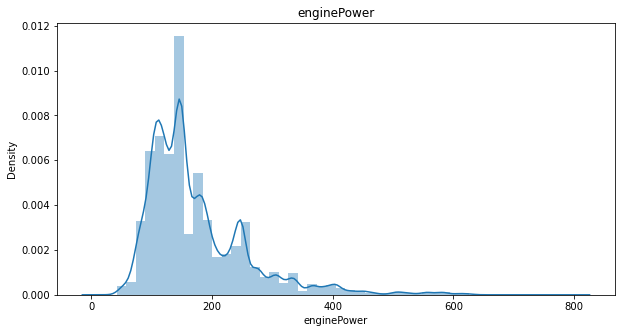

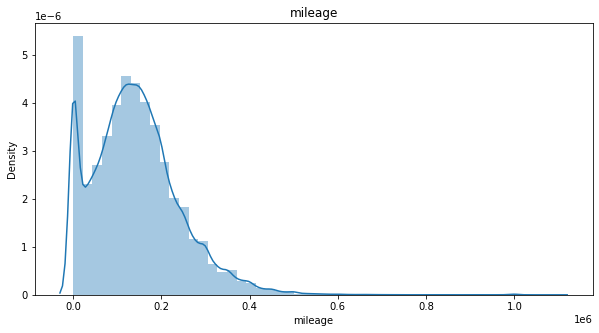

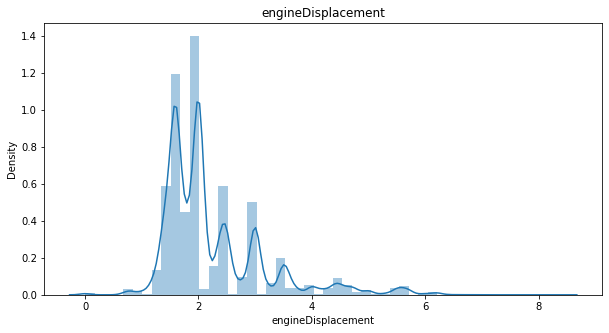

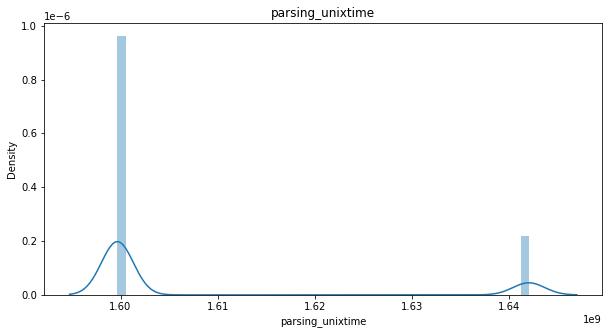

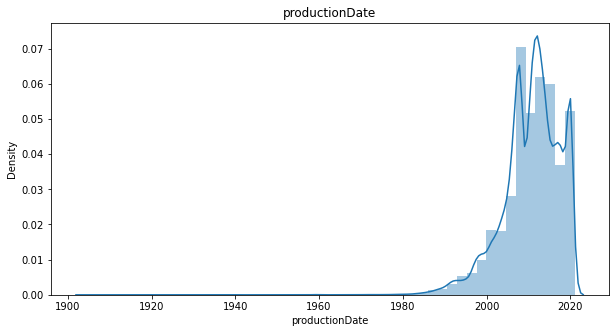

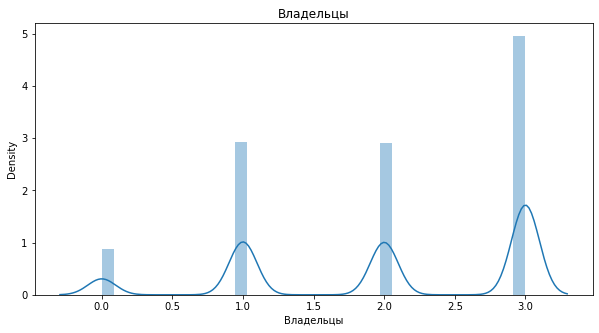

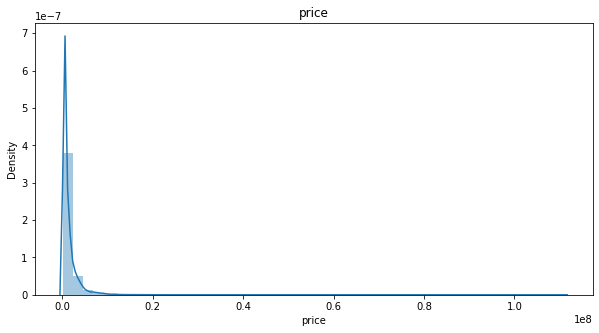

In [113]:
# посмотрим на распределение числовых признаков
for i in num_cols:
    plt.figure(figsize=(10, 5))
    sns.distplot(data[data['sample'] == 1][i].dropna())
    plt.title(i)
    plt.show()

Для того чтобы сделать распределение числовых переменных более нормальным, прологарифмируем их значения

In [114]:
# for i in num_cols:
#     data[i] = data[i].apply(lambda w: np.log(w+1))

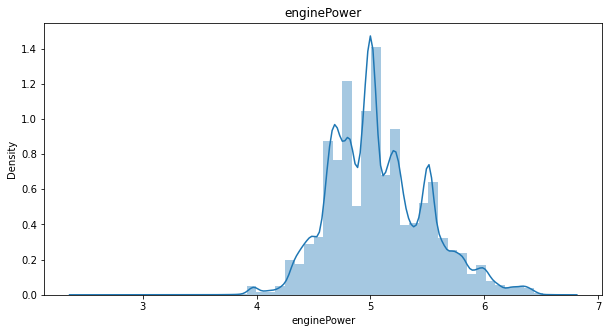

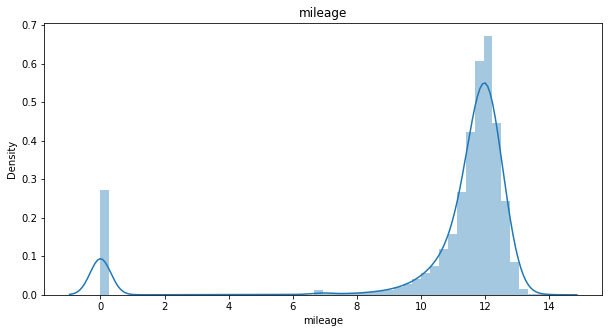

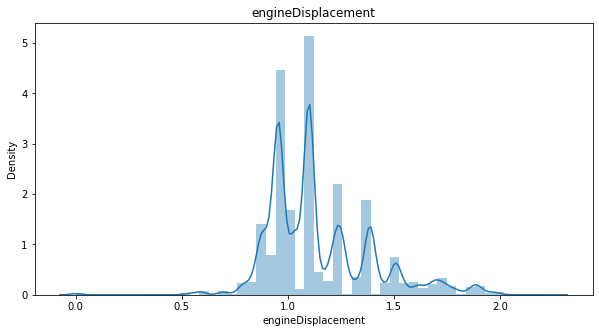

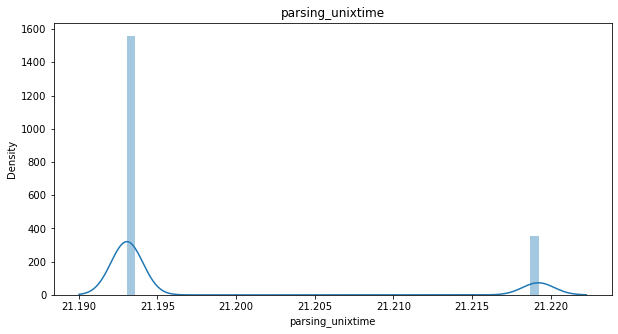

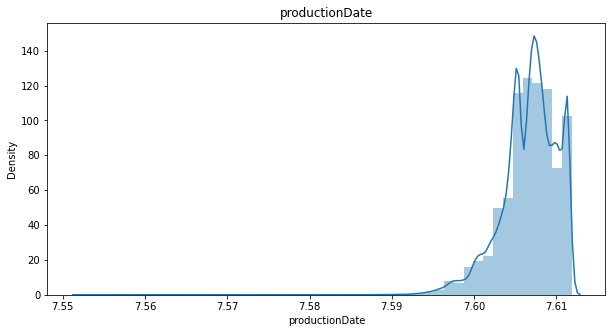

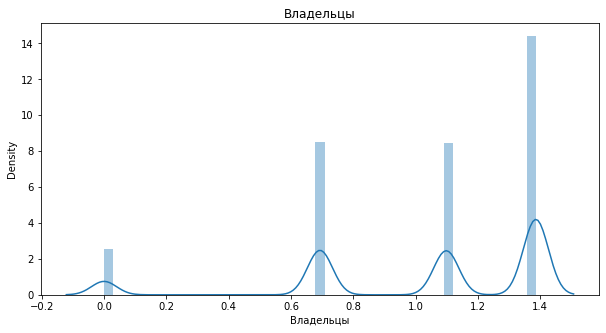

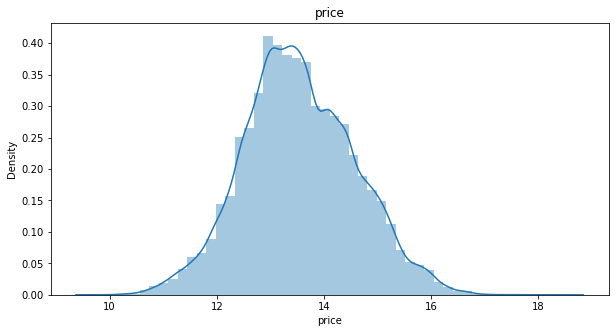

In [115]:
# еще раз посмотрим на распределение числовых признаков
for i in num_cols:
    plt.figure(figsize=(10, 5))
    sns.distplot(data[data['sample'] == 1][i].dropna())
    plt.title(i)
    plt.show()

В случае с engineDisplacement и enginePower распределение стало более нормальным. Будем логарифмировать тогда значения только для этих столбцов.

In [87]:
for i in ['enginePower', 'engineDisplacement']:
    data[i] = data[i].apply(lambda w: np.log(w+1))

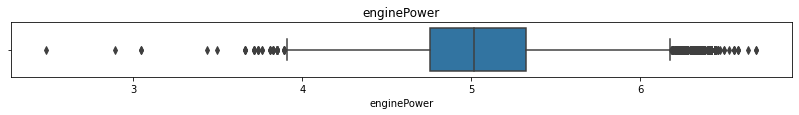

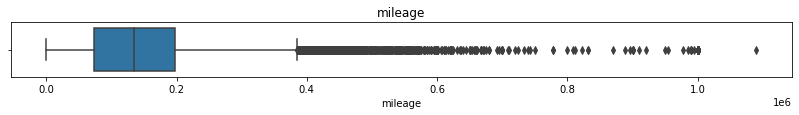

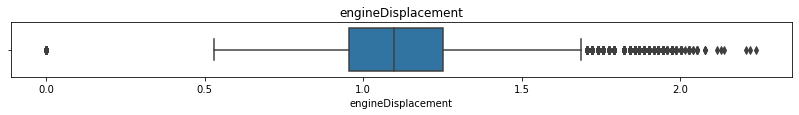

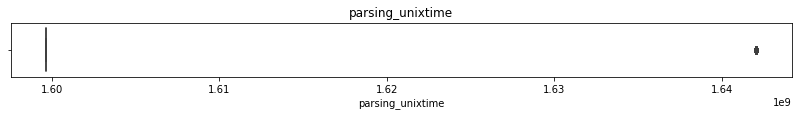

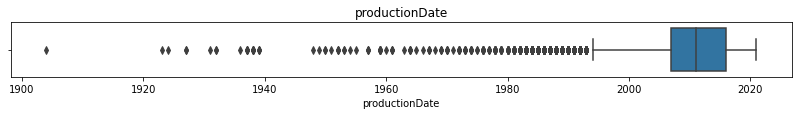

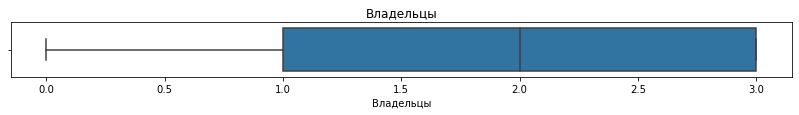

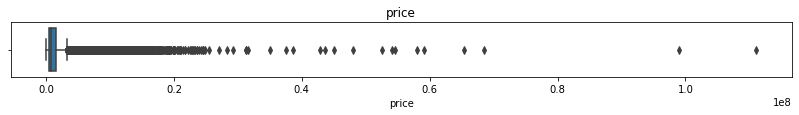

In [396]:
# посмотрим на выбросы в числовых переменных
for i in num_cols:
    plt.figure(figsize=(14, 1))
    sns.boxplot(data[data['sample'] == 1][i].dropna())
    plt.title(i)
    plt.show()

In [397]:
outlier('productionDate')

('25%: 2007.0,',
 '75%: 2015.0,',
 'IQR: 8.0, ',
 'Outlier bounds: [1995.0, 2027.0].')

In [398]:
# многовато значений для удаления, пока оставим
data[data['productionDate']<1995].productionDate.value_counts()

1992    654
1993    631
1994    602
1991    539
1990    353
1989    271
1988    231
1987    161
1986    116
1985    100
1984     69
1983     54
1982     35
1981     25
1980     22
1978     15
1976     12
1979     12
1959     10
1972      9
1973      7
1977      7
1974      7
1937      6
1938      6
1969      5
1970      5
1953      4
1939      4
1964      4
1975      4
1967      4
1961      4
1952      4
1957      4
1950      3
1965      3
1932      2
1927      2
1948      2
1949      2
1963      2
1960      2
1904      2
1936      2
1968      2
1955      1
1971      1
1931      1
1923      1
1924      1
1951      1
1954      1
1966      1
Name: productionDate, dtype: int64

In [399]:
outlier('engineDisplacement')

('25%: 0.9555114450274363,',
 '75%: 1.252762968495368,',
 'IQR: 0.2972515234679317, ',
 'Outlier bounds: [0.5096341598255387, 1.6986402536972656].')

In [400]:
# многовато значений для удаления, пока оставим
data[data['engineDisplacement']>1.6986402536972656].engineDisplacement.value_counts()

1.740466    976
1.704748    971
1.871802    906
1.791759    619
1.902108    582
1.887070    521
1.722767    425
1.757858    372
1.974081    250
1.945910    163
1.840550    107
1.856298     93
1.824549     54
1.931521     37
1.774952     23
1.916923     22
1.987874     19
2.028148     18
2.001480     16
1.960095     10
2.054124      6
2.079442      3
2.041220      2
2.219203      1
2.208274      1
2.140066      1
2.128232      1
2.014903      1
2.240710      1
2.116256      1
Name: engineDisplacement, dtype: int64

In [401]:
outlier('enginePower')

('25%: 4.770684624465665,',
 '75%: 5.356586274672012,',
 'IQR: 0.5859016502063472, ',
 'Outlier bounds: [3.8918321491561443, 6.235438749981533].')

In [402]:
# многовато значений для удаления, пока оставим
data[data['enginePower']>6.235438749981533].enginePower.value_counts()

6.373320    244
6.236370    161
6.320768    158
6.356108    111
6.418365    100
6.274762     80
6.265301     78
6.439350     73
6.349139     69
6.300786     69
6.329721     59
6.324359     49
6.249975     47
6.398595     34
6.311735     33
6.326149     27
6.406880     21
6.255750     17
6.364751     12
6.293419     11
6.413459     11
6.447306      9
6.415097      7
6.338594      6
6.440947      4
6.461468      4
6.244167      4
6.552508      3
6.576470      3
6.383507      3
6.496775      2
6.685861      2
6.257668      2
6.261492      2
6.380123      2
6.336826      2
6.267201      1
6.555357      1
6.347389      1
6.242223      1
6.635947      1
6.523562      1
6.259581      1
6.472346      1
6.411818      1
Name: enginePower, dtype: int64

**Оценим корреляцию Пирсона для числовых переменных**

<AxesSubplot:>

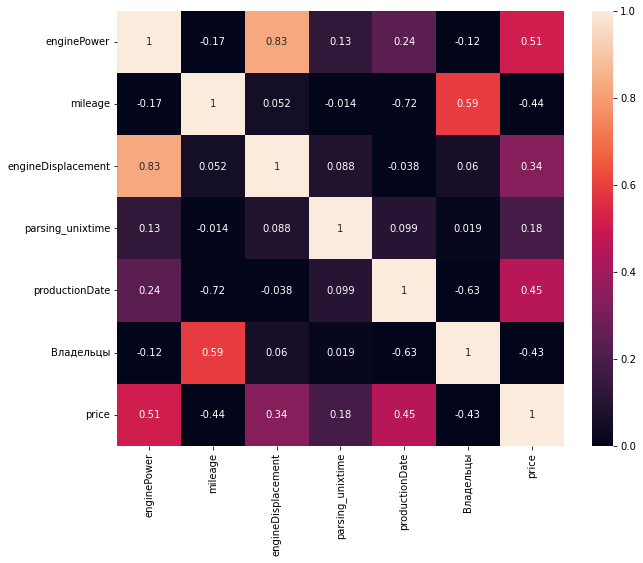

In [63]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.heatmap(data[data['sample'] == 1][num_cols].corr(),
            vmin=0, vmax=1, annot=True)

Наибольшая корреляция наблюдается между enginePower и engineDisplacement - 0.85. Также высокая корреляция между Владельцами и пробегом, что логично. Цена коррелирует с enginePower, productionDate и engineDisplacement.

enginePower больше коррелирует с ценой, поэтому удалим engineDisplacement. Владельцы и mileage имеют одинаково отрицательную корреляцию с ценой, удалим Владельцев.

In [88]:
data.drop(columns=['engineDisplacement', 'Владельцы'], inplace=True)

Оценим значимость числовых переменных с помощью функции f_classif из библиотеки sklearn.
В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для модели.

<AxesSubplot:>

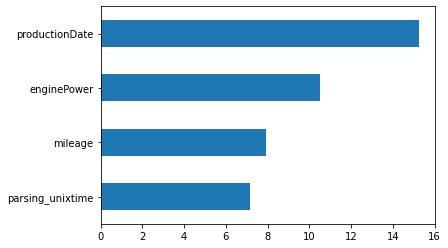

In [404]:
num_cols = ['enginePower', 'mileage', 'productionDate', 'parsing_unixtime']

imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols],
                    data[data['sample'] == 1]['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Наиболее значимыми из числовых признаков являются productionDate и enginePower.

In [336]:
# пробовала добавлять нормализацию числовых признаков, на точность моделей это практически не влияет
# num_cols = ['enginePower', 'mileage', 'productionDate', 'parsing_unixtime']
# data[num_cols] = MinMaxScaler().fit_transform(data[num_cols].values)

## Feature engineering

In [89]:
# добавим возраст авто в годах
data['years_old'] = 2021 - data['productionDate']
data['years_old'].replace([np.inf, -np.inf], 0, inplace=True)

# добавим отношение года выпуска к пробегу
data['production_to_mileage'] = data['productionDate'] / data['mileage']
data['production_to_mileage'].replace([np.inf, -np.inf], 0, inplace=True)

# добавим пробег в год
data['mileage_per_year'] = data['mileage'] / data['years_old']
data['mileage_per_year'].replace([np.inf, -np.inf], 0, inplace=True)

# добавим количество слов в описании
data['descr_words_count'] = data['description'].apply(
    lambda x: len(x.split()) if isinstance(x, str) else 0)
data['descr_words_count'].replace([np.inf, -np.inf], 0, inplace=True)

# добавим бинарные столбцы
# 'владелец' и 'дилер' из описания
data['description'] = data['description'].map(lambda x: str(x).lower())
data['owner'] = data['description'].apply(
    lambda x: 1 if 'торг' in x or 'не нуждаюсь' in x or len(x) < 200 else 0)
data['dealer'] = data['description'].apply(lambda x: 1 if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or 'клиент' in x
                                           or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x
                                           or 'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)

# 'старое' авто для года выпуска до 1980
data['old_car'] = data['productionDate'].apply(lambda x: 1 if x < 1980 else 0)
# автомобилю 3 года или меньше
data['0_3_years_old'] = data['years_old'].apply(lambda x: 1 if x <= 3 else 0)
# автомобилю 5 лет или меньше
data['0_5_years_old'] = data['years_old'].apply(lambda x: 1 if x <= 5 else 0)
# выделим редкие типы кузова
data['rare_bodytype'] = data['bodyType'].apply(lambda x: 1 if x in [
                                               'микровэн', 'седан-хардтоп', 'лимузин', 'тарга', 'фастбек'] else 0)
# выделим редкие цвета
data['rare_color'] = data['color'].apply(lambda x: 1 if x in [
    'золотистый', 'пурпурный', 'жёлтый', 'фиолетовый', 'оранжевый', 'розовый'] else 0)

In [95]:
# удалим описание
data.drop(['description'], inplace=True, axis=1)

<AxesSubplot:>

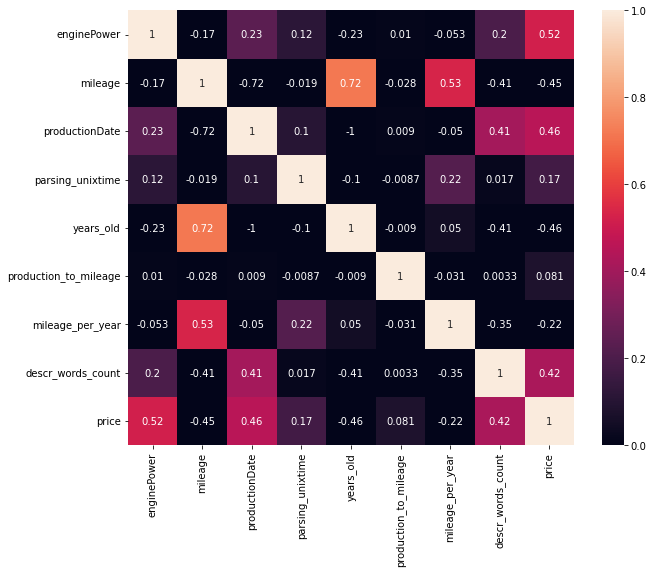

In [73]:
# снова посмотрим на корреляцию числовых признаков с учетом добавленных
num_cols = ['enginePower', 'mileage', 'productionDate', 'parsing_unixtime',
            'years_old', 'production_to_mileage', 'mileage_per_year', 'descr_words_count']

plt.rcParams['figure.figsize'] = (10, 8)
sns.heatmap(data[data['sample'] == 1][num_cols + ['price']].corr(),
            vmin=0, vmax=1, annot=True)

<AxesSubplot:>

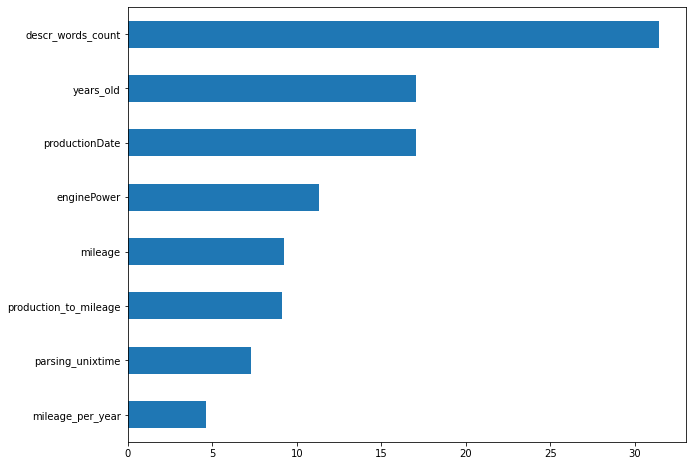

In [74]:
# снова посмотрим на важность числовых признаков с учетом добавленных
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols],
                    data[data['sample'] == 1]['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [96]:
# удалим коррелирующие признаки
data.drop(['years_old', 'mileage_per_year'], inplace=True, axis=1)

<AxesSubplot:>

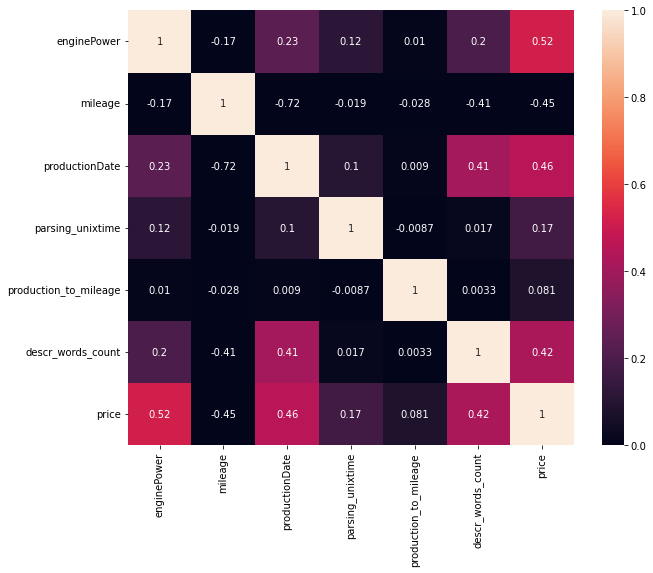

In [97]:
# снова посмотрим на корреляцию числовых признаков с учетом добавленных
num_cols = ['enginePower', 'mileage', 'productionDate', 'parsing_unixtime',
            'production_to_mileage', 'descr_words_count']

plt.rcParams['figure.figsize'] = (10, 8)
sns.heatmap(data[data['sample'] == 1][num_cols + ['price']].corr(),
            vmin=0, vmax=1, annot=True)

## Label Encoding

In [101]:
# список бинарных переменных
bin_cols = ['Таможня', 'owner', 'dealer', 'old_car', '0_3_years_old',
            '0_5_years_old', 'rare_bodytype', 'rare_color']

In [102]:
for column in cat_cols:
    data[column] = data[column].astype('category').cat.codes

**Оценим корреляцию Пирсона для категориальных и бинарных переменных**

<AxesSubplot:>

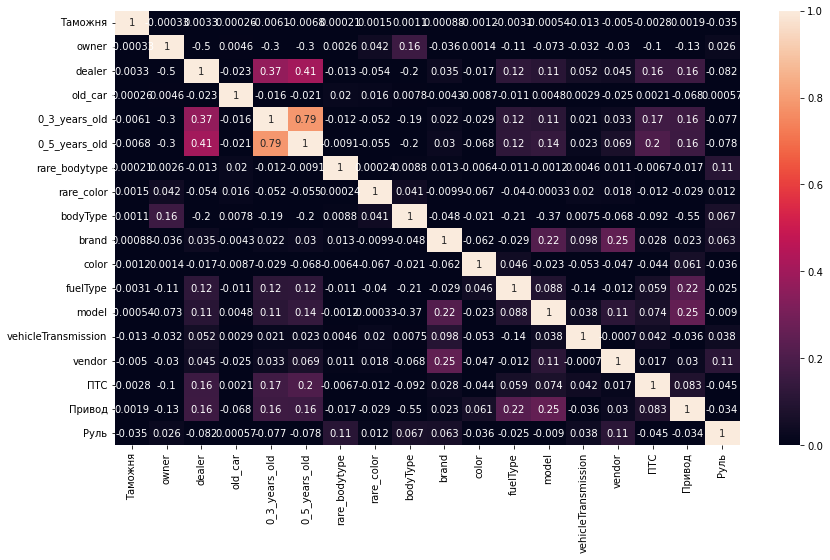

In [104]:
plt.rcParams['figure.figsize'] = (14, 8)
sns.heatmap(data[data['sample'] == 1][bin_cols + cat_cols].corr(),
            vmin=0, vmax=1, annot=True)

Наблюдаем высокую корреляцию между 0_3_years_old и 0_5_years_old; 0_3_years_old, 0_5_years_old c dealer.

<AxesSubplot:>

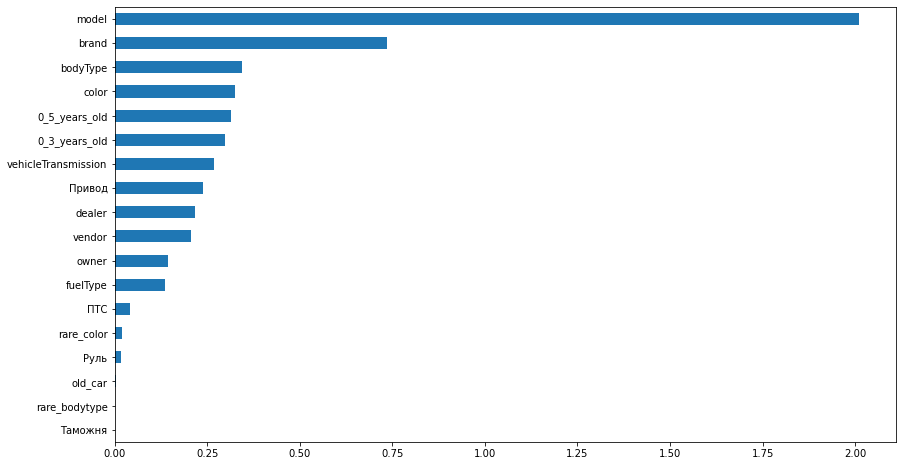

In [106]:
imp_cat = Series(mutual_info_classif(data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['price'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Наиболее значимыми из категориальных признаков являются model, brand и bodyType.

In [107]:
# удалим коррелирующие признаки
data.drop(['0_3_years_old', 'dealer'], inplace=True, axis=1)

In [229]:
# пробовала удалить vendor, коррелириующий с brand (0,25) и Привод, коррелириующий с fuelType и model (~0,25)
# точность моделей стала ниже
# data.drop(columns=['vendor', 'Привод'], inplace=True)

# пробовала удалять Руль и Таможню, точность моделей стала ниже
# data.drop(columns=['Руль', 'Таможня'], inplace=True)

In [110]:
data.head()

bodyType  brand  color  enginePower  fuelType  mileage  model  \
0         6     29     13     4.663439         0    74000    736   
1         6     29     15     4.709530         0    60563    736   
2         6     29     12     5.030438         0    88000    990   
3         6     29      6     4.709530         0    95000    736   
4         6     29      1     5.030438         0    58536    736   

   parsing_unixtime  productionDate  vehicleTransmission  vendor  ПТС  Привод  \
0        1603226273            2014                    2       2    1       1   
1        1603226277            2017                    1       2    1       1   
2        1603226280            2014                    2       2    1       1   
3        1603226284            2014                    0       2    1       1   
4        1603226288            2012                    0       2    1       1   

   Руль  Таможня  sample  price  production_to_mileage  descr_words_count  \
0     0        1       0    0.0               0.027216                145   
1     0        1       0    0.0               0.033304                357   
2     0        1       0    0.0               0.022886                145   
3     0        1       0    0.0               0.021200                238   
4     0        1       0    0.0               0.034372                322   

   owner  old_car  0_5_years_old  rare_bodytype  rare_color  
0      0        0              0              0           0  
1      0        0              1              0           0  
2      0        0              0              0           0  
3      1        0              0              0           0  
4      0        0              0              0           0

In [ ]:
# переименуем столбцы
data.rename(columns=({'ПТС': 'pts', 'Привод': 'privod', 'Руль': 'steering_wheel', 'Таможня': 'customs'}), inplace=True)

## Train Split

In [111]:
train_df = data.query('sample == 1').drop(['sample'], axis=1)
test_df = data.query('sample == 0').drop(['sample', 'price'], axis=1)
X = train_df.drop(['price'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)
y = train_df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# "Наивная" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [164]:
# для baseline просто возьму пару схожих признаков без полной обработки
columns = ['bodyType', 'brand', 'productionDate',
           'engineDisplacement', 'mileage']
df_train = train[columns]
df_test = test[columns]

df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест

# объединяем
data = df_test.append(df_train, sort=False).reset_index(
    drop=True)

for column in ['bodyType', 'brand', 'engineDisplacement']:
    data[column] = data[column].astype('category').cat.codes

X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)
y = train['price']

In [170]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [171]:
# находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(
    tmp_train.groupby('engineDisplacement')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: nan%


1. Точность наивной модели по метрике MAPE: **108.23% (baseline)**
2. Точность наивной модели по метрике MAPE: **89.62%** (columns: 'bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'mileage', 'modelDate', 'model', 'numberOfDoors', 'productionDate', 'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'Таможня', без cтандартизации числовых переменных, без удаления коррелирующих)

На основании сравнения результатов трех моделей было принято решение далее везде брать логарифм от таргета. Сравнение проводилось на одном датасете (п. 4), без подбора параметров модели: 
- catboost 13.5% c log vs 16%
- randomforest 14.3% c log vs 15.7%
- xgboost 14.6% с log vs 18.2%

# CatBoost

In [61]:
catboost_model = CatBoostRegressor(iterations=5000,
                                   random_seed=RANDOM_SEED,
                                   eval_metric='MAPE',
                                   custom_metric=['R2', 'MAE'],
                                   silent=True,
                                   )
catboost_model.fit(X_train, y_train,
                   # cat_features=cat_features_ids,
                   eval_set=(X_test, y_test),
                   verbose_eval=0,
                   use_best_model=True,
                   # plot=True
                   )

catboost_model.save_model('catboost_single_model_baseline.model')

In [62]:
# оцениваем точность
predict = catboost_model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 16.04%


1. Точность модели по метрике MAPE: **17.89% (baseline)**  
2. Точность модели по метрике MAPE: 0.82% (columns: 'bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'mileage', 'modelDate', 'model', 'numberOfDoors', 'productionDate', 'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'Таможня', без cтандартизации числовых переменных, без удаления коррелирующих)
3. Точность модели по метрике MAPE: **15.79%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'modelDate', 'model', 'numberOfDoors', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', **удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации и логарифмирования числовых переменных**)
4. Точность модели по метрике MAPE: **16.04%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга**)

### Log Target
Попробуем взять таргет в логарифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp)

In [152]:
np.log(y_train)

37978     14.214286
90971     13.710150
105563    14.054527
117168    12.923912
47304     12.782686
            ...    
40951     13.487006
89572     12.043554
111506    14.346139
35546     12.611538
50481     12.072541
Name: price, Length: 80968, dtype: float64

In [112]:
catboost_log_model = CatBoostRegressor(iterations=5000,
                                      random_seed=RANDOM_SEED,
                                      eval_metric='MAPE',
                                      custom_metric=['R2', 'MAE'],
                                      silent=True,
                                      )
catboost_log_model.fit(X_train, np.log(y_train),
                      # cat_features=cat_features_ids,
                      eval_set=(X_test, np.log(y_test)),
                      verbose_eval=0,
                      use_best_model=True,
                      # plot=True
                      )

catboost_log_model.save_model('catboost_single_model_log_baseline.model')

In [113]:
predict_test = np.exp(catboost_log_model.predict(X_test))
predict_submission = np.exp(catboost_log_model.predict(X_sub))

In [114]:
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.42%


4. Точность модели по метрике MAPE: **13.48%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без нормализации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
5. Точность модели по метрике MAPE: **13.77%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'ПТС', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без нормализации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + удалены vendor и Привод**)
6. Точность модели по метрике MAPE: **13.63%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'ПТС', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без нормализации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + удалены Руль и Таможня как неважные признаки**)
7. Точность модели по метрике MAPE: **13.60%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без нормализации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + поправка на инфляцию для данных парсинга**)
8. Точность модели по метрике MAPE: **13.62%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, **с нормализацией**, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
9. Точность модели по метрике MAPE: **13.42%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', 'sample', 'price', 'production_to_mileage', 'descr_words_count', 'owner', 'old_car', '0_5_years_old', 'rare_bodytype', 'rare_color', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без нормализации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + feature engineering**)

# RandomForest

In [301]:
rf_model = RandomForestRegressor(random_state=RANDOM_SEED)
rf_model.fit(X_train, np.log(y_train)) 
predict_rf = np.exp(rf_model.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_rf)) * 100:0.2f}%")

Точность модели по метрике MAPE: 14.51%


4. Точность модели по метрике MAPE: **14.31%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
5.
6. Точность модели по метрике MAPE: **14.53%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'ПТС', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + удалены Руль и Таможня как неважные признаки**)
7. Точность модели по метрике MAPE: **14.42%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + поправка на инфляцию для данных парсинга**)

**Подбор параметров**

In [304]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [305]:
rf_model = RandomForestRegressor(random_state=RANDOM_SEED)
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid, n_iter=100,
                               cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, np.log(y_train))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [306]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [116]:
rf_model = RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=1600, min_samples_split=5,
                                 min_samples_leaf=1, max_features='sqrt', max_depth=70, bootstrap=False)
rf_model.fit(X_train, np.log(y_train))
predict_rf = np.exp(rf_model.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_rf)) * 100:0.2f}%")

Точность модели по метрике MAPE: 14.10%


8. Точность модели по метрике MAPE: **13.96%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
9. Точность модели по метрике MAPE: **13.95%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, **с нормализацией**, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
10. Точность модели по метрике MAPE: **14.10%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', 'sample', 'price', 'production_to_mileage', 'descr_words_count', 'owner', 'old_car', '0_5_years_old', 'rare_bodytype', 'rare_color', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без нормализации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + feature engineering**)

# xgboost

In [117]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED)
xgb_model.fit(X_train, np.log(y_train))
predict_xgb = np.exp(xgb_model.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_xgb))*100:0.2f}%")

Точность модели по метрике MAPE: 14.66%


4. Точность модели по метрике MAPE: **14.64%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
5. Точность модели по метрике MAPE: **15.10%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'ПТС', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + удалены vendor и Привод**)
6. Точность модели по метрике MAPE: **14.95%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'ПТС', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + удалены Руль и Таможня как неважные признаки**)
7. Точность модели по метрике MAPE: **14.75%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + поправка на инфляцию для данных парсинга**)

**Подбор параметров**

In [310]:
param_dic = {'max_depth': [4, 5, 7],
            'min_child_weight': [1, 3],
            'learning_rate': [0.05, 0.1, 0.3]}

xgb_grid = GridSearchCV(xgb_model, param_dic, n_jobs=-1,
                        refit=True, return_train_score=True, verbose=5)

xgb_grid.fit(X_train, np.log(y_train))

print(xgb_grid.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1}


In [118]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED,
                             learning_rate=0.3, max_depth=7, min_child_weight=1)
xgb_model.fit(X_train, np.log(y_train))
predict_xgb = np.exp(xgb_model.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_xgb))*100:0.2f}%")

Точность модели по метрике MAPE: 14.29%


8. Точность модели по метрике MAPE: **14.34%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
9. Точность модели по метрике MAPE: **14.50%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, **с нормализацией**, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
10. Точность модели по метрике MAPE: **14.29%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', 'sample', 'price', 'production_to_mileage', 'descr_words_count', 'owner', 'old_car', '0_5_years_old', 'rare_bodytype', 'rare_color', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без нормализации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + feature engineering**)

# LGBMRegressor 

In [303]:
lgbm_model = LGBMRegressor(objective='regression', random_state=RANDOM_SEED)
lgbm_model.fit(X_train, np.log(y_train))
predict_lgbm = np.exp(lgbm_model.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_lgbm))*100:0.2f}%")

Точность модели по метрике MAPE: 16.27%


4. Точность модели по метрике MAPE: **16.14%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
5. Точность модели по метрике MAPE: **16.56%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'ПТС', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + удалены vendor и Привод**)
6. Точность модели по метрике MAPE: **16.24%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'ПТС', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + удалены Руль и Таможня как неважные признаки**)
7. Точность модели по метрике MAPE: **16.20%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + поправка на инфляцию для данных парсинга**)

**Подбор параметров**

In [312]:
param_dic = {'min_child_weight': [0.001, 0.005, 0.01],
             'num_leaves': [15, 31, 60, 100],
             'colsample_bytree': [0.05, 0.1, 0.2, 0.5, 1],
             'min_child_samples': [10, 20, 30]}

lgbm_grid = GridSearchCV(lgbm_model, param_dic, n_jobs=-1,
                         refit=True, return_train_score=True,  verbose=5)

lgbm_grid.fit(X_train, np.log(y_train))
print(lgbm_grid.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'colsample_bytree': 1, 'min_child_samples': 30, 'min_child_weight': 0.001, 'num_leaves': 100}


In [119]:
lgbm_model = LGBMRegressor(objective='regression', random_state=RANDOM_SEED,
                           colsample_bytree=1, min_child_samples=30, min_child_weight=0.001, num_leaves=100)
lgbm_model.fit(X_train, np.log(y_train))
predict_lgbm = np.exp(lgbm_model.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_lgbm))*100:0.2f}%")

Точность модели по метрике MAPE: 14.37%


8. Точность модели по метрике MAPE: **14.69%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
9. Точность модели по метрике MAPE: **14.60%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, **с нормализацией**, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
10. Точность модели по метрике MAPE: **14.37%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', 'sample', 'price', 'production_to_mileage', 'descr_words_count', 'owner', 'old_car', '0_5_years_old', 'rare_bodytype', 'rare_color', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без нормализации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + feature engineering**)

# Bagging

### Bagging над LGBMRegressor

In [120]:
bagging_model = BaggingRegressor(lgbm_model, random_state=RANDOM_SEED).fit(X_train, np.log(y_train))
predict_bagging = np.exp(bagging_model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bagging))*100:0.2f}%")

Точность модели по метрике MAPE: 14.30%


4. Точность модели по метрике MAPE: **16.01%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
5.
6.
7. Точность модели по метрике MAPE: **16.10%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + поправка на инфляцию для данных парсинга**)
8. Точность модели по метрике MAPE: **14.60%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + подбор параметров для lgbm_model**)
9. Точность модели по метрике MAPE: **14.30%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', 'sample', 'price', 'production_to_mileage', 'descr_words_count', 'owner', 'old_car', '0_5_years_old', 'rare_bodytype', 'rare_color', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без нормализации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + feature engineering**)

### Bagging над xgboost

In [121]:
bagging_model = BaggingRegressor(xgb_model,  random_state=RANDOM_SEED).fit(X_train, np.log(y_train))
predict_bagging = np.exp(bagging_model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bagging))*100:0.2f}%")

Точность модели по метрике MAPE: 13.60%


4. Точность модели по метрике MAPE: **14.06%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
5.
6.
7. Точность модели по метрике MAPE: **14.16%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + поправка на инфляцию для данных парсинга**)
8. Точность модели по метрике MAPE: **13.82%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + подбор параметров для xgb_model**)
9. Точность модели по метрике MAPE: **13.6%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', 'sample', 'price', 'production_to_mileage', 'descr_words_count', 'owner', 'old_car', '0_5_years_old', 'rare_bodytype', 'rare_color', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без нормализации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + feature engineering**)

# Stacking

In [122]:
catboost_st = CatBoostRegressor(iterations=5000,
                                random_seed=RANDOM_SEED,
                                eval_metric='MAPE',
                                # custom_metric=['R2', 'MAE'],
                                silent=True,)

In [123]:
models = [('lg', lgbm_model), ('xg', xgb_model)]

stacking_regr = StackingRegressor(estimators=models,
                                  final_estimator=catboost_st,
                                  cv=3)

stacking_regr.fit(X_train, np.log(y_train))

StackingRegressor(cv=3,
                  estimators=[('lg',
                               LGBMRegressor(colsample_bytree=1,
                                             min_child_samples=30,
                                             num_leaves=100,
                                             objective='regression',
                                             random_state=42)),
                              ('xg',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.3, max_delta_step

In [124]:
predict_stacking = np.exp(stacking_regr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_stacking))*100:0.2f}%")

Точность модели по метрике MAPE: 14.09%


4. Точность модели по метрике MAPE: **14.85%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target)**)
5.
6.
7. Точность модели по метрике MAPE: **15.01%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + поправка на инфляцию для данных парсинга**)
8. Точность модели по метрике MAPE: **14.33%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без стандартизации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + подбор параметров для xgb_model и lgbm_model**)
9. Точность модели по метрике MAPE: **14.09%** (columns: 'bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'model', 'parsing_unixtime', 'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль', 'Таможня', 'sample', 'price', 'production_to_mileage', 'descr_words_count', 'owner', 'old_car', '0_5_years_old', 'rare_bodytype', 'rare_color', удалила engineDisplacement и Владельцы из-за положительной корреляции с другими признаками, удалила дубли в train после чистки, без нормализации, с логарифмированием числовых переменных, **добавлены данные парсинга + np.log(target) + feature engineering**)

# Submission

Самая высокая точность у модели CatBoost с логарифмированным таргетом, за ней идет Bagging над xgboost, третье место делят RandomForestRegressor и Stacking.

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.